# Implement and train a LSTM for sentiment analysis

(General Hint on Lab 1/2: Trust whatever you see from the training and report it on PDF. IDMB is far from ideal as it's more like a real-world dataset)

## Step 0: set up the environment

In [1]:
import sys
print(sys.executable)

/home/yl826/anaconda3/envs/michael/bin/python


In [2]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
# import tqdm
from tqdm.auto import tqdm  # my addition
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from typing import Tuple, Dict, List

nltk.download('stopwords')

torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

[nltk_data] Downloading package stopwords to /home/yl826/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
'cuda' if torch.cuda.is_available() else 'cpu'  # my addition

'cuda'

### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [4]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = set(stopwords.words('english'))
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 5

        
ORIG_HPARAMS = HyperParams()

In [5]:
import inspect 

def diff_hparams(orig_hp: HyperParams, new_hp: HyperParams) -> str:
    """
    @param orig_hp: original hyperparameters, class HyperParams
    @param new_hp: hyperparameters that have different values
    return string containing attr and vals that are different 
    e.g.
    org_hyperparams = HyperParams(); new_hyperparams = HyperParams()
    new_hyperparams.N_LAYERS = 10; new_hyperparams.BIDIRECTIONAL = True
    diff_hparams(org_hyperparams, new_hyperparams)
    
    return 'BIDIRECTIONAL=True,N_LAYERS=10'
    """
    attr_orig = inspect.getmembers(orig_hp, lambda a:not(inspect.isroutine(a)))
    attr_orig_filtered = [a for a in attr_orig if not(a[0].startswith('__') and a[0].endswith('__'))]
    
    attr_new = inspect.getmembers(new_hp, lambda a:not(inspect.isroutine(a)))
    attr_new_filtered = [a for a in attr_new if not(a[0].startswith('__') and a[0].endswith('__'))]
    diff_hparams_dict = {}
    for idx, (n, val) in enumerate(attr_new_filtered):
        if val != attr_orig_filtered[idx][1]:
            diff_hparams_dict[n] = val
    ret = ""
    for idx, (k, v) in enumerate(diff_hparams_dict.items()):
        if type(v) == int or type(v) == float:
            ret = ret + '%s=%g,' % (k, v)
        if type(v) == bool:
            ret = ret + '%s=%r,' % (k, v)
        if type(v) == str:
            ret = ret + '%s=%s,' % (k, v)
        if idx % 4 == 0:
            ret = ret + '\n'
    return ret[0:-1]


def plot_train_val_acc(save_name, ret_dict, orig_hp, new_hp, save, gru=False):

    fig, ax = plt.subplots(1, 1)
    xx = np.linspace(1, orig_hp.N_EPOCHS, orig_hp.N_EPOCHS)

    ax.plot(xx, ret_dict['train_accs'], label='Train')
    ax.plot(xx, ret_dict['valid_accs'], 
            label='Validation; max accuracy=%.4f' % (np.max(ret_dict['valid_accs'])))
    ax.set_ylim([0.45, 1.05])

    diff_param = diff_hparams(orig_hp=orig_hp, new_hp=new_hp)
    
    lstm_or_gru = {False: 'LSTM', True: 'GRU'}
    
    if len(diff_param) != 0:
        title_ = lstm_or_gru[gru] + ';' + diff_param
    else:
        title_ = lstm_or_gru[gru]
    title_ += ';test_acc:%.4f' % ret_dict['test_acc']
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(title_)
    fig.tight_layout()
    if save == 'y':
        if len(diff_param) != 0:
            plt.savefig('%s_%s.pdf' % (save_name, diff_param.strip()), dpi=500, bbox_inches='tight')
        else:
            plt.savefig('%s_default_hp.pdf' % (save_name), dpi=500, bbox_inches='tight')
    return 

## Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk. 
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [6]:
from sklearn.model_selection import train_test_split  # my addition

def preprocessing_string(s):  # my addition
    return s


def load_imdb(base_csv:str = './IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here. 
    df = pd.read_csv('IMDBDataset.csv')
    x = list(df['review'])
    y = list(df['sentiment'])
    # 7:3 train/(test&Val) ratio
    x_train, x_testVal, y_train, y_testVal = train_test_split(x, y, test_size=0.3, 
                                                              random_state=1002, 
                                                              shuffle=True)
    # 1:2 val='train'/test ratio
    x_valid, x_test, y_valid, y_test = train_test_split(x_testVal, y_testVal, 
                                                        test_size=float(2/3), 
                                                        random_state=1002, 
                                                        shuffle=True)
    # I'm only to run this function once, so it shouldn't matter across different trainings if I shuffle. 
    # random seed is set, so should be constant across different kernel sessions.
    print(f'shape of train data is {len(x_train)}')
    print(f'shape of test data is {len(x_test)}')
    print(f'shape of valid data is {len(x_valid)}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

## Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus.
Use the given preprocess_string() function to process each word by "preprocess_string(word)".
Avoid the words that are in the STOP_WORDS. 
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [7]:
def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.
    
    # split x_train into words 
    words_temp = []
    for sent in x_train:
        words_lst = sent.split()
        words_lst_lower = [w.lower() for w in words_lst]
        words_temp.extend(words_lst_lower)
    # no additional string preprocessing

    corpus = Counter([w for w in words_temp if w not in hparams.STOP_WORDS])
    
    # sorting on the basis of most common words
    # corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # creating a dict
    vocab = {word : idx + 2 for idx, word in enumerate(corpus_)}
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab


# vocab = build_vocab(x_train, hparams=hparams)

## Lab 1(c): Implement your tokenize function. 
You should leverage the given preprocess_string() function to process each word by "preprocess_string(word)".
For each word, find its index in the vocabulary. 
Return a list of int that represents the indices of words in the example. 

In [8]:
def tokenize(vocab: dict, example: str) -> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    # Your code here.
    ex_tok = example.split()
    ex = [w.lower() for w in ex_tok]
    # return [vocab[w] if w in vocab else vocab[ORIG_HPARAMS.UNK_TOKEN] for w in ex]
    return [vocab[w] for w in ex if w in vocab]


# for index, (word, idx) in enumerate(vocab.items()):
#     print(word, idx)
#     if index > 10:
#         break
# example_tokens = tokenize(vocab=vocab, example="This probably the worst ever movie made."
#                           " Roger Corman the best")
# print(example_tokens)

## Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label. 
The review is originally a string. Please tokenize it into a sequence of token indices. 
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens. 
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0. 
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label. 

In [9]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 
        'label' which represent the list of token ids, 
        the length of the sequence, the binary label.
        """
        # Add your code here.
        pn_dict = {'positive': 1, 'negative': 0}
        
        review, binary_label = tokenize(vocab=self.vocab, example=self.x[idx]), pn_dict[self.y[idx]]  
        # print(len(review), review[0:2])
        if len(review) > self.max_length:
            return {'ids': review[0:self.max_length], 'length': self.max_length, 'label': binary_label}
        else:
            return {'ids': review, 'length': len(review), 'label': binary_label}
        
    def __len__(self) -> int:
        return len(self.x)

    
def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch


# imdb_obj = IMDB(x=x_train, y=y_train, vocab=vocab)
# print(imdb_obj[2])
collate_fn = collate

## Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout. 
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length. 
    Apply a fully-connected (fc) layer to the output of the LSTM layer. 
    Return the output features which is of size [batch size, output dim]. 

In [10]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
                
class LSTM(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.pad_index = pad_index
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim, padding_idx=pad_index, 
                                      max_norm=None, norm_type=2.0, scale_grad_by_freq=False, 
                                      sparse=False, _weight=None, _freeze=False, 
                                      device=None, dtype=None)
        lstm_dropout = None
        if n_layers > 1:
            lstm_dropout = dropout_rate
        else:
            lstm_dropout = 0.0
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=n_layers, bias=True, batch_first=True, 
                            dropout=lstm_dropout, bidirectional=bidirectional, proj_size=0, 
                            device=None, dtype=None)
        # dropout=0.0 in self.lstm since n_layers is only 1 and the last lstm layer 
        # doesn't have any dropout
        # batch_first=True since ids is batch_size * sequence_len
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim, 
                            bias=True, device=None, dtype=None)
        if bidirectional: # bidirectional: 2*hidden_dim is needed 
            # since lstm output is double the size
            self.fc = nn.Linear(in_features=2*hidden_dim, out_features=output_dim, 
                                bias=True, device=None, dtype=None)
        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # note: using batch_first=True
        # do we need to pad? the dataloader seems to be pretty good at padding
        # NO NEED to use nn.utils.rnn.pad_sequence since collate_fn already pads everything
        # and each batch has already been padded.
        padded_ids = nn.utils.rnn.pad_sequence(sequences=ids, batch_first=True, 
                                               padding_value=self.pad_index)
        
        # Add your code here.
        out = self.embedding(padded_ids)
        # packs the embeddings (better for computation)
        out = nn.utils.rnn.pack_padded_sequence(out, length, batch_first=True, enforce_sorted=False)
        
        # Pass embedded input through the LSTM and dropout layers
        out, hidden = self.lstm(out)
        # otuput of lstm is packed sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, 
                                                  padding_value=self.pad_index)
        # unpack the packed thing, should result in tensor of shape (batch size, seq len, hidden_size)
        # link to explain the range indexing below: take out every length-1-th element for each batch
        # https://stackoverflow.com/questions/53123009/using-python-range-objects-to-index-into-numpy-arrays
        out = self.dropout(out[range(out.shape[0]), length.int() - 1, :])
        # dropout(tensor of shape [batch_size, hidden_dim]) i.e. apply dropout on 
        # last hidden state of each input in the batch
        
        prediction = self.fc(out)
        # Get the output from the last time step
        return prediction

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    # orig: tqdm.tqdm(dataloader, desc='training...', file=sys.stdout) with import tqdm
    # for batch in tqdm(dataloader, desc='training...', file=sys.stdout, miniters=int(223265/100)):
    for batch in tqdm(dataloader, desc='training...', file=sys.stdout, disable=True):
        # my addition
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        # orig: tqdm.tqdm(dataloader, desc='training...', file=sys.stdout) with import tqdm
        # for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout, miniters=int(223265/100)):
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout, disable=True):
            # my addition
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [12]:
class GRU(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.pad_index = pad_index
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim, padding_idx=pad_index, 
                                      max_norm=None, norm_type=2.0, scale_grad_by_freq=False, 
                                      sparse=False, _weight=None, _freeze=False, 
                                      device=None, dtype=None)
        gru_dropout = None
        if n_layers > 1:
            gru_dropout = dropout_rate
        else:
            gru_dropout = 0.0
        
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, 
                          num_layers=n_layers, bias=True, batch_first=True, 
                          dropout=gru_dropout, bidirectional=bidirectional, 
                          device=None, dtype=None)
        
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim, 
                            bias=True, device=None, dtype=None)
        if bidirectional:  # hidden_dim*2, same reason as in LSTM
            self.fc = nn.Linear(in_features=hidden_dim*2, out_features=output_dim, 
                                bias=True, device=None, dtype=None)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Weight Initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        
        # DO NOT need to use nn.utils.rnn.pad_sequence since collate_fn already pads everything
        # and each batch has already been padded.
        padded_ids = nn.utils.rnn.pad_sequence(sequences=ids, batch_first=True, 
                                               padding_value=self.pad_index)
        out = self.embedding(padded_ids)
        out = nn.utils.rnn.pack_padded_sequence(out, length, batch_first=True, enforce_sorted=False)
        
        out, _ = self.gru(out)  # second output is hidden state
        
        # unpack gru_out since it's packed, results in tensor of shape (batch size, seq len, hidden_size)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, 
                                                  padding_value=self.pad_index)
        
        # Apply dropout to the GRU output
        out = self.dropout(out[range(out.shape[0]), length.int() - 1, :])
        # array indexing: 
        # for each input, take the last non-padded hidden state (which is where length comes in). 
        # ends up with tensor of shape [batch size, hidden_dim]
        
        prediction = self.fc(out)
        return prediction

### Learning rate warmup. DO NOT TOUCH!

In [13]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [14]:
CHECKPOINT_FOLDER = "./saved_model/"
# computes x_train, x_valid... etc once only for all models
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()


def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    vocab = build_vocab(x_train, hparams=hparams)

    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')
    # use x_train, x_valid, x_test, y_train, y_valid, y_test as global
    # better for comparing betw models.
    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    
    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
        model = LSTM(
            vocab_size, 
            hparams.EMBEDDING_DIM, 
            hparams.HIDDEN_DIM, 
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE, 
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)        
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    for epoch in range(hparams.N_EPOCHS):
        
        # Your code: implement the training process and save the best model.

        train_loss, train_acc = train(dataloader=train_dataloader, model=model, 
                                      criterion=criterion, optimizer=optimizer, 
                                      scheduler=lr_scheduler, device=device)

        valid_loss, valid_acc = evaluate(dataloader=valid_dataloader, model=model, 
                                         criterion=criterion, device=device)
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)
        
        # my addition
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        # Save the model that achieves the smallest validation loss.
        if epoch_valid_loss < best_valid_loss:
            best_val_acc = epoch_valid_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': epoch}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'hw3_LSTM.pth'))
            # Your code: save the best model somewhere (no need to submit it to Sakai)

        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


    # Your Code: Load the best model's weights.
    
    state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER + 'hw3_LSTM.pth'))['state_dict']
    model.load_state_dict(state_dict)
    model = model.cuda()
    
    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_loss, test_acc = evaluate(dataloader=test_dataloader, model=model, 
                                   criterion=criterion, device=device)

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')
    
    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
        "train_loss": train_losses, 
        "train_accs": train_accs, 
        "valid_loss": valid_losses, 
        "valid_accs": valid_accs
    }

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000


### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [15]:
org_hyperparams = HyperParams()
rd_1f = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 98,131 trainable parameters
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.501
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.501
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.694, valid_acc: 0.501
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.694, valid_acc: 0.499
test_loss: 0.694, test_acc: 0.500


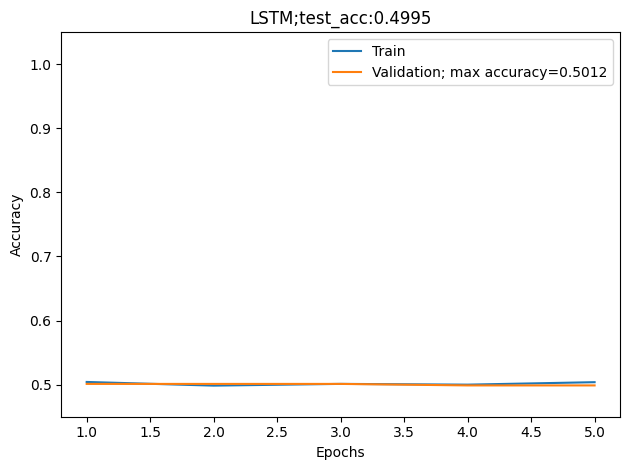

In [16]:
plot_train_val_acc(save_name='q1f', ret_dict=rd_1f, orig_hp=ORIG_HPARAMS, 
                   new_hp=org_hyperparams, save='y', gru=False)

### Lag 1 (h) Train GRU with vanilla hyperparameters.

In [17]:
org_hyperparams = HyperParams()
rd_1h = train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", 
                                          override_models_with_gru=True)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 87,831 trainable parameters
Saving ...
epoch: 1
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.694, valid_acc: 0.499
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.501
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.506
valid_loss: 0.694, valid_acc: 0.499
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.694, valid_acc: 0.499
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.507
valid_loss: 0.693, valid_acc: 0.501
test_loss: 0.693, test_acc: 0.500


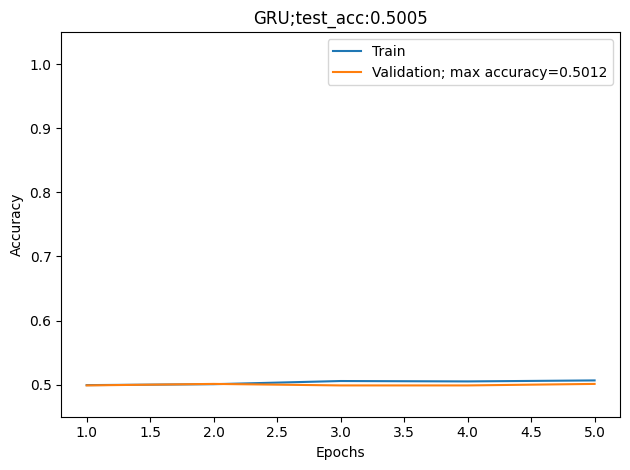

In [18]:
plot_train_val_acc(save_name='q1h', ret_dict=rd_1h, orig_hp=ORIG_HPARAMS, 
                   new_hp=org_hyperparams, save='y', gru=True)

### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [19]:
q2a_adagrad_hparams = HyperParams()
q2a_adagrad_hparams.LR = 0.001
q2a_adagrad_hparams.OPTIM = 'adagrad'
rd_2a_adagrad = train_and_test_model_with_hparams(hparams=q2a_adagrad_hparams, model_type="lstm")

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 98,131 trainable parameters
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.570
Saving ...
epoch: 2
train_loss: 0.690, train_acc: 0.563
valid_loss: 0.636, valid_acc: 0.748
Saving ...
epoch: 3
train_loss: 0.587, train_acc: 0.773
valid_loss: 0.592, valid_acc: 0.765
Saving ...
epoch: 4
train_loss: 0.514, train_acc: 0.831
valid_loss: 0.535, valid_acc: 0.814
Saving ...
epoch: 5
train_loss: 0.481, train_acc: 0.849
valid_loss: 0.510, valid_acc: 0.829
test_loss: 0.506, test_acc: 0.825


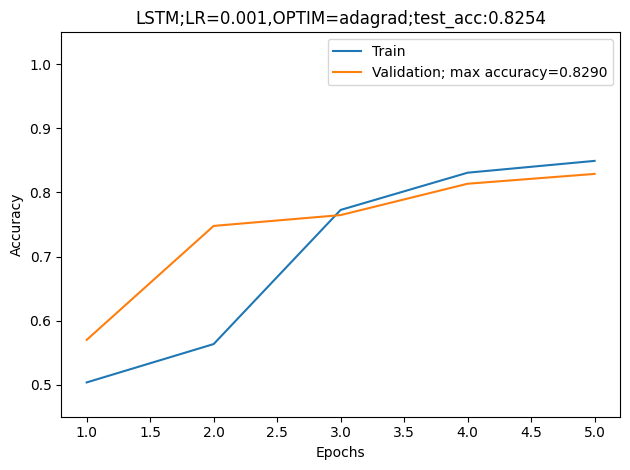

In [20]:
plot_train_val_acc(save_name='q2a_adagrad', ret_dict=rd_2a_adagrad, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2a_adagrad_hparams, save='y', gru=False)

In [21]:
q2a_rmsprop_hparams = HyperParams()
q2a_rmsprop_hparams.LR = 0.001
q2a_rmsprop_hparams.OPTIM = 'rmsprop'
rd_2a_rmsprop = train_and_test_model_with_hparams(hparams=q2a_rmsprop_hparams, model_type="lstm")

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 98,131 trainable parameters
Saving ...
epoch: 1
train_loss: 0.583, train_acc: 0.690
valid_loss: 0.468, valid_acc: 0.781
Saving ...
epoch: 2
train_loss: 0.354, train_acc: 0.847
valid_loss: 0.349, valid_acc: 0.856
Saving ...
epoch: 3
train_loss: 0.175, train_acc: 0.936
valid_loss: 0.296, valid_acc: 0.881
Saving ...
epoch: 4
train_loss: 0.101, train_acc: 0.966
valid_loss: 0.350, valid_acc: 0.862
Saving ...
epoch: 5
train_loss: 0.058, train_acc: 0.982
valid_loss: 0.406, valid_acc: 0.874
test_loss: 0.438, test_acc: 0.870


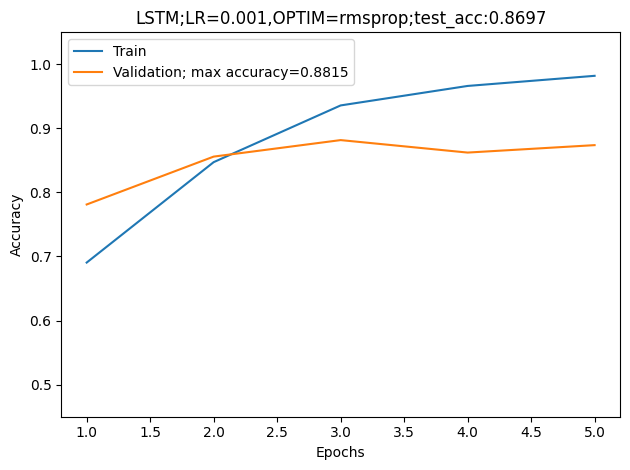

In [22]:
plot_train_val_acc(save_name='q2a_rmsprop', ret_dict=rd_2a_rmsprop, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2a_rmsprop_hparams, save='y', gru=False)

In [23]:
q2a_adam_hparams = HyperParams()
q2a_adam_hparams.LR = 0.001
q2a_adam_hparams.OPTIM = 'adam'
rd_2a_adam = train_and_test_model_with_hparams(hparams=q2a_adam_hparams, model_type="lstm")

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 98,131 trainable parameters
Saving ...
epoch: 1
train_loss: 0.633, train_acc: 0.607
valid_loss: 0.417, valid_acc: 0.800
Saving ...
epoch: 2
train_loss: 0.273, train_acc: 0.891
valid_loss: 0.293, valid_acc: 0.874
Saving ...
epoch: 3
train_loss: 0.144, train_acc: 0.950
valid_loss: 0.294, valid_acc: 0.873
Saving ...
epoch: 4
train_loss: 0.082, train_acc: 0.974
valid_loss: 0.335, valid_acc: 0.878
Saving ...
epoch: 5
train_loss: 0.048, train_acc: 0.987
valid_loss: 0.416, valid_acc: 0.875
test_loss: 0.444, test_acc: 0.869


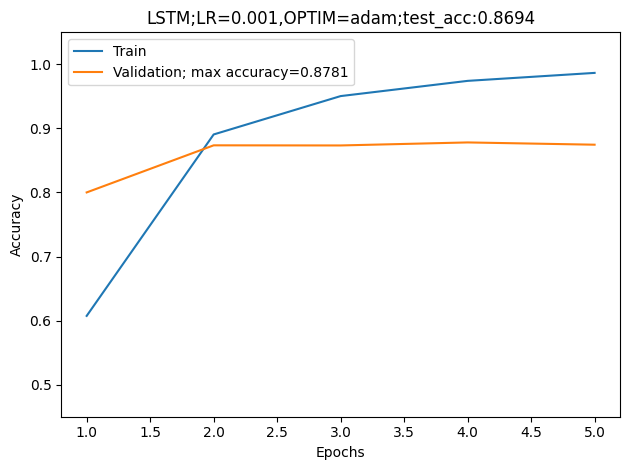

In [24]:
plot_train_val_acc(save_name='q2a_adam', ret_dict=rd_2a_adam, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2a_adam_hparams, save='y', gru=False)

### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [25]:
q2b_adagrad_hparams = HyperParams()
q2b_adagrad_hparams.LR = 0.001
q2b_adagrad_hparams.OPTIM = 'adagrad'
rd_2b_adagrad = train_and_test_model_with_hparams(q2b_adagrad_hparams, "gru", 
                                                  override_models_with_gru=True)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 87,831 trainable parameters
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.507
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 2
train_loss: 0.629, train_acc: 0.697
valid_loss: 0.587, valid_acc: 0.772
Saving ...
epoch: 3
train_loss: 0.496, train_acc: 0.847
valid_loss: 0.489, valid_acc: 0.840
Saving ...
epoch: 4
train_loss: 0.434, train_acc: 0.873
valid_loss: 0.466, valid_acc: 0.850
Saving ...
epoch: 5
train_loss: 0.390, train_acc: 0.886
valid_loss: 0.438, valid_acc: 0.853
test_loss: 0.430, test_acc: 0.858


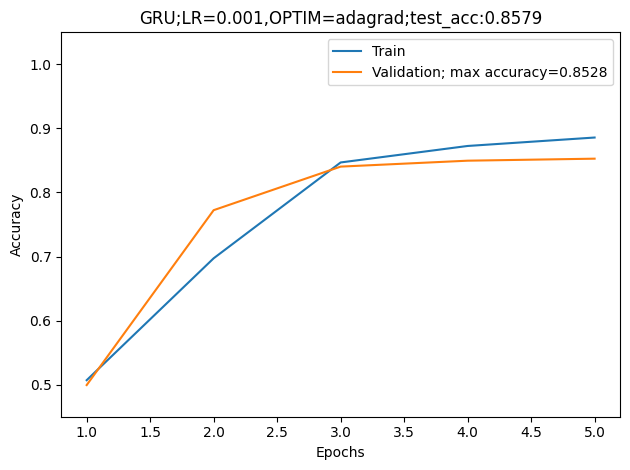

In [26]:
plot_train_val_acc(save_name='q2b_adagrad', ret_dict=rd_2b_adagrad, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2b_adagrad_hparams, save='y', gru=True)

In [27]:
q2b_rmsprop_hparams = HyperParams()
q2b_rmsprop_hparams.LR = 0.001
q2b_rmsprop_hparams.OPTIM = 'rmsprop'
rd_2b_rmsprop = train_and_test_model_with_hparams(q2b_rmsprop_hparams, "gru", 
                                                  override_models_with_gru=True)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 87,831 trainable parameters
Saving ...
epoch: 1
train_loss: 0.432, train_acc: 0.779
valid_loss: 0.295, valid_acc: 0.879
Saving ...
epoch: 2
train_loss: 0.171, train_acc: 0.937
valid_loss: 0.259, valid_acc: 0.894
Saving ...
epoch: 3
train_loss: 0.086, train_acc: 0.969
valid_loss: 0.363, valid_acc: 0.877
Saving ...
epoch: 4
train_loss: 0.041, train_acc: 0.986
valid_loss: 0.511, valid_acc: 0.848
Saving ...
epoch: 5
train_loss: 0.026, train_acc: 0.991
valid_loss: 0.585, valid_acc: 0.875
test_loss: 0.606, test_acc: 0.869


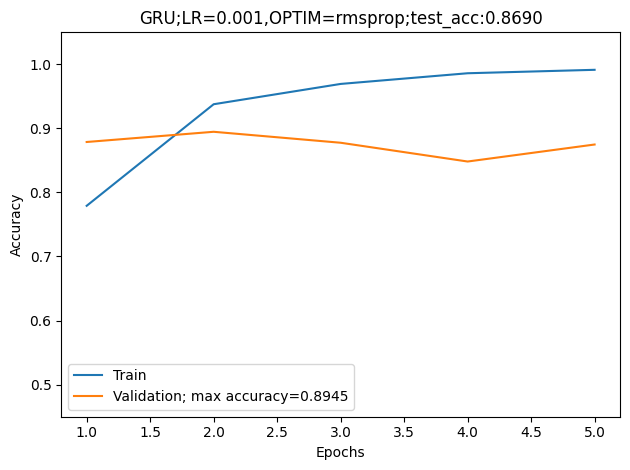

In [28]:
plot_train_val_acc(save_name='q2b_rmsprop', ret_dict=rd_2b_rmsprop, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2b_rmsprop_hparams, save='y', gru=True)

In [29]:
q2b_adam_hparams = HyperParams()
q2b_adam_hparams.LR = 0.001
q2b_adam_hparams.OPTIM = 'adam'
rd_2b_adam = train_and_test_model_with_hparams(q2b_adam_hparams, "gru", 
                                               override_models_with_gru=True)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 87,831 trainable parameters
Saving ...
epoch: 1
train_loss: 0.590, train_acc: 0.656
valid_loss: 0.439, valid_acc: 0.822
Saving ...
epoch: 2
train_loss: 0.227, train_acc: 0.911
valid_loss: 0.260, valid_acc: 0.891
Saving ...
epoch: 3
train_loss: 0.113, train_acc: 0.963
valid_loss: 0.337, valid_acc: 0.886
Saving ...
epoch: 4
train_loss: 0.051, train_acc: 0.985
valid_loss: 0.389, valid_acc: 0.879
Saving ...
epoch: 5
train_loss: 0.027, train_acc: 0.992
valid_loss: 0.632, valid_acc: 0.878
test_loss: 0.637, test_acc: 0.878


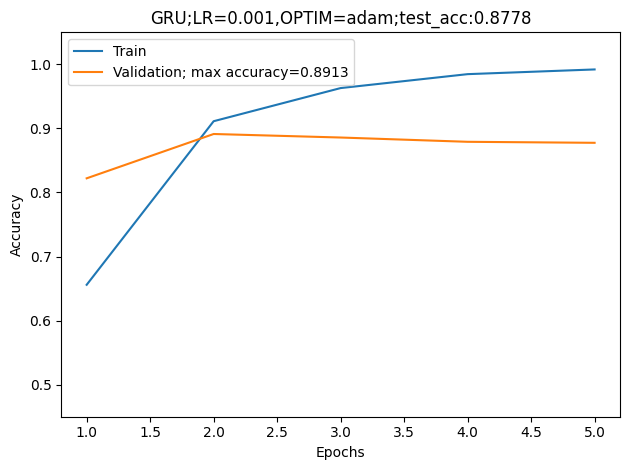

In [30]:
plot_train_val_acc(save_name='q2b_adam', ret_dict=rd_2b_adam, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2b_adam_hparams, save='y', gru=True)

### Lab 2 (c) Deeper LSTMs

In [31]:
# Try to make your RNN model deeper by changing the number of layers. 
# Is your RNN model achieving a better accuracy on IDMB classification? 
# You may use LSTM as an example. 
# Hint: you do not need to explore more than 4 recurrent layers in a RNN model

def assert_n_layers(hp_):
    n_layers_min, n_layers_max = 2, 4
    assert hp_.N_LAYERS >= 2 and hp_.N_LAYERS <= 4


def train_lab2c(num_layers):
    # using lstm. returns ret_dict and hyperparameters instance, changes N_LAYERS
    q2c_rmsprop_HP = HyperParams()
    q2c_rmsprop_HP.LR = 0.001
    q2c_rmsprop_HP.OPTIM = 'rmsprop'

    q2c_rmsprop_HP.N_LAYERS = num_layers
    assert_n_layers(hp_=q2c_rmsprop_HP)

    ret_dict_2c = train_and_test_model_with_hparams(hparams=q2c_rmsprop_HP, model_type="lstm")
    return ret_dict_2c, q2c_rmsprop_HP

In [32]:
q2c_rd2, q2c_hp2 = train_lab2c(num_layers=2)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 178,931 trainable parameters
Saving ...
epoch: 1
train_loss: 0.573, train_acc: 0.683
valid_loss: 0.370, valid_acc: 0.843
Saving ...
epoch: 2
train_loss: 0.256, train_acc: 0.898
valid_loss: 0.294, valid_acc: 0.872
Saving ...
epoch: 3
train_loss: 0.141, train_acc: 0.949
valid_loss: 0.308, valid_acc: 0.886
Saving ...
epoch: 4
train_loss: 0.079, train_acc: 0.974
valid_loss: 0.315, valid_acc: 0.882
Saving ...
epoch: 5
train_loss: 0.046, train_acc: 0.986
valid_loss: 0.385, valid_acc: 0.872
test_loss: 0.396, test_acc: 0.866


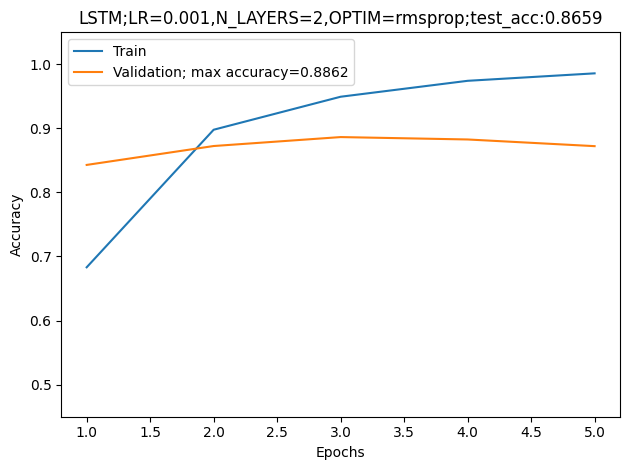

In [33]:
plot_train_val_acc(save_name='q2c', ret_dict=q2c_rd2, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2c_hp2, save='y', gru=False)

In [34]:
q2c_rd3, q2c_hp3 = train_lab2c(num_layers=3)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 259,731 trainable parameters
Saving ...
epoch: 1
train_loss: 0.691, train_acc: 0.513
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.501
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.697, valid_acc: 0.501
Saving ...
epoch: 4
train_loss: 0.692, train_acc: 0.527
valid_loss: 0.699, valid_acc: 0.499
Saving ...
epoch: 5
train_loss: 0.683, train_acc: 0.568
valid_loss: 0.685, valid_acc: 0.501
test_loss: 0.687, test_acc: 0.500


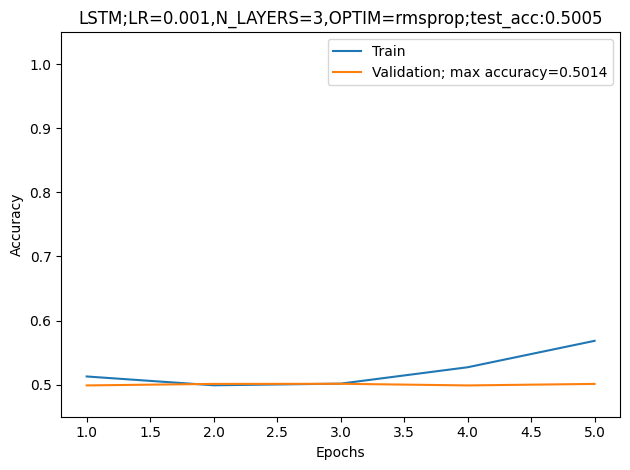

In [35]:
plot_train_val_acc(save_name='q2c', ret_dict=q2c_rd3, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2c_hp3, save='y', gru=False)

In [36]:
q2c_rd4, q2c_hp4 = train_lab2c(num_layers=4)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 340,531 trainable parameters
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.501
Saving ...
epoch: 4
train_loss: 0.694, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.499
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.501
test_loss: 0.693, test_acc: 0.500


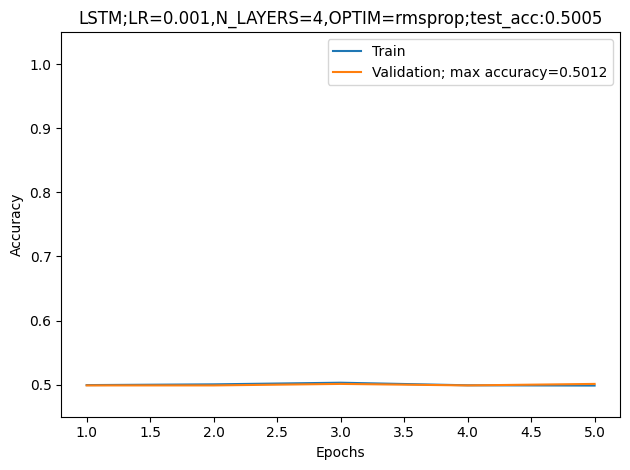

In [37]:
plot_train_val_acc(save_name='q2c', ret_dict=q2c_rd4, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2c_hp4, save='y', gru=False)

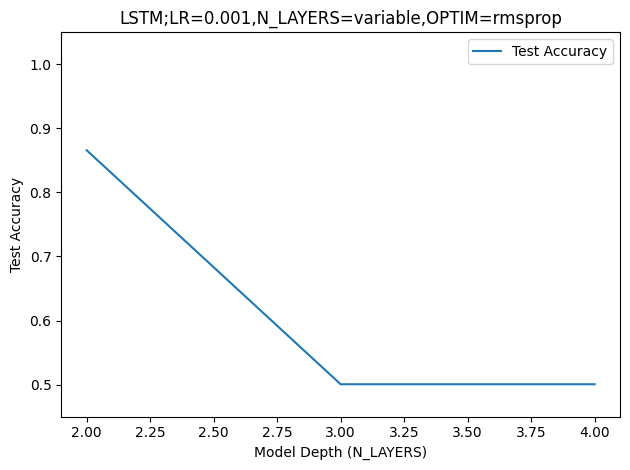

In [78]:
test_losses_q2c = [q2c_rd2['test_acc'], q2c_rd3['test_acc'], q2c_rd4['test_acc']]
q2c_nlayers = [2, 3, 4]

fig, ax = plt.subplots(1, 1)

ax.plot(q2c_nlayers, test_losses_q2c, label='Test Accuracy')

ax.set_ylim([0.45, 1.05])

# diff_param = diff_hparams(orig_hp=orig_hp, new_hp=new_hp)

title_ = "LSTM;LR=0.001,N_LAYERS=variable,OPTIM=rmsprop"

ax.set_xlabel('Model Depth (N_LAYERS)')
ax.set_ylabel('Test Accuracy')
ax.legend()
ax.set_title(title_)
fig.tight_layout()

plt.savefig('q2c_overall.pdf', dpi=500, bbox_inches='tight')

### Lab 2 (d) Wider LSTMs

In [38]:
# Try to make your RNN model wider by changing the number of hidden units. 
# Is your RNN model achieving a better accuracy on IDMB classification? You may use LSTM as an example. 
# (Hint: you do not need to explore a hidden dimension of more than 320 on IMDB).

def assert_h_dim(hp_):
    hidden_dim_max = 320
    assert hp_.HIDDEN_DIM <= 320 and hp_.HIDDEN_DIM >=10


def train_lab2d(hidden_dimension):
    # HIDDEN_DIM
    # using lstm. returns ret_dict and hyperparameters instance, changes HIDDEN_DIM
    q2d_rmsprop_HP = HyperParams()
    q2d_rmsprop_HP.LR = 0.001
    q2d_rmsprop_HP.OPTIM = 'rmsprop'

    q2d_rmsprop_HP.HIDDEN_DIM = hidden_dimension
    assert_h_dim(hp_=q2d_rmsprop_HP)

    ret_dict_2d = train_and_test_model_with_hparams(hparams=q2d_rmsprop_HP, model_type="lstm")
    return ret_dict_2d, q2d_rmsprop_HP

In [39]:
q2d_rd_10, q2d_hp_10 = train_lab2d(hidden_dimension=10)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 57,271 trainable parameters
Saving ...
epoch: 1
train_loss: 0.506, train_acc: 0.750
valid_loss: 0.395, valid_acc: 0.839
Saving ...
epoch: 2
train_loss: 0.287, train_acc: 0.889
valid_loss: 0.330, valid_acc: 0.878
Saving ...
epoch: 3
train_loss: 0.152, train_acc: 0.947
valid_loss: 0.330, valid_acc: 0.871
Saving ...
epoch: 4
train_loss: 0.093, train_acc: 0.970
valid_loss: 0.378, valid_acc: 0.857
Saving ...
epoch: 5
train_loss: 0.060, train_acc: 0.982
valid_loss: 0.430, valid_acc: 0.876
test_loss: 0.457, test_acc: 0.873


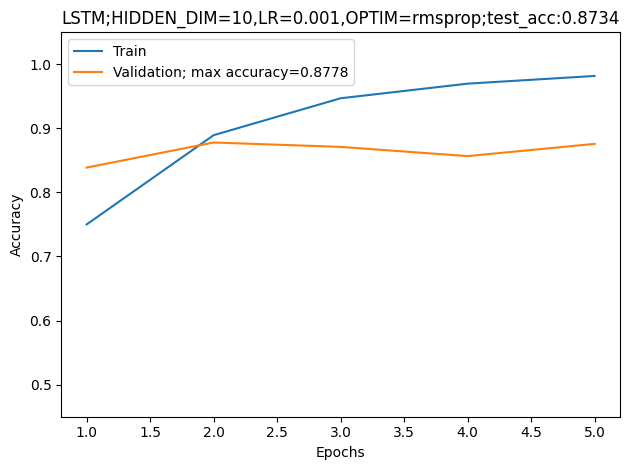

In [40]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_10, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_10, save='y', gru=False)

In [41]:
q2d_rd_20, q2d_hp_20 = train_lab2d(hidden_dimension=20)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 58,611 trainable parameters
Saving ...
epoch: 1
train_loss: 0.543, train_acc: 0.723
valid_loss: 0.367, valid_acc: 0.856
Saving ...
epoch: 2
train_loss: 0.282, train_acc: 0.893
valid_loss: 0.348, valid_acc: 0.854
Saving ...
epoch: 3
train_loss: 0.175, train_acc: 0.939
valid_loss: 0.431, valid_acc: 0.855
Saving ...
epoch: 4
train_loss: 0.103, train_acc: 0.966
valid_loss: 0.395, valid_acc: 0.850
Saving ...
epoch: 5
train_loss: 0.066, train_acc: 0.979
valid_loss: 0.449, valid_acc: 0.873
test_loss: 0.477, test_acc: 0.867


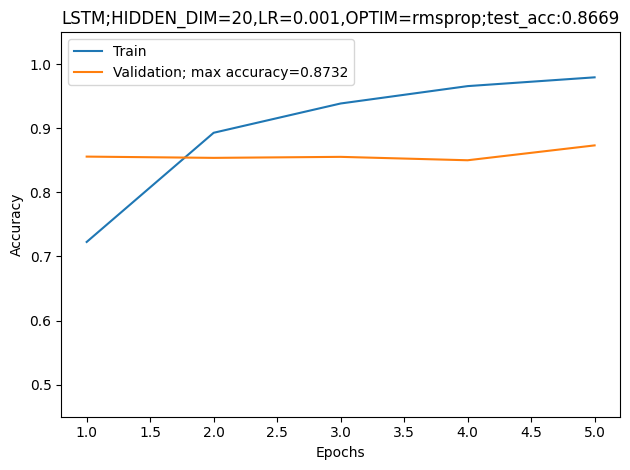

In [42]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_20, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_20, save='y', gru=False)

In [43]:
q2d_rd_150, q2d_hp_150 = train_lab2d(hidden_dimension=150)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 148,831 trainable parameters
Saving ...
epoch: 1
train_loss: 0.692, train_acc: 0.577
valid_loss: 0.766, valid_acc: 0.513
Saving ...
epoch: 2
train_loss: 0.496, train_acc: 0.760
valid_loss: 0.353, valid_acc: 0.861
Saving ...
epoch: 3
train_loss: 0.384, train_acc: 0.835
valid_loss: 0.592, valid_acc: 0.683
Saving ...
epoch: 4
train_loss: 0.361, train_acc: 0.841
valid_loss: 0.413, valid_acc: 0.830
Saving ...
epoch: 5
train_loss: 0.186, train_acc: 0.930
valid_loss: 0.356, valid_acc: 0.859
test_loss: 0.370, test_acc: 0.858


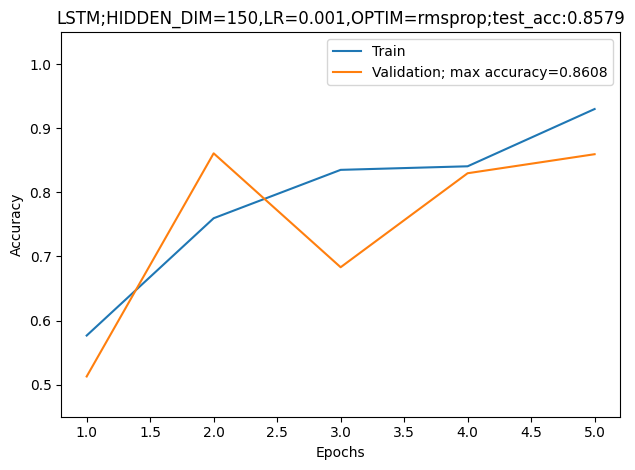

In [44]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_150, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_150, save='y', gru=False)

In [45]:
q2d_rd_200, q2d_hp_200 = train_lab2d(hidden_dimension=200)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 219,531 trainable parameters
Saving ...
epoch: 1
train_loss: 0.784, train_acc: 0.529
valid_loss: 0.649, valid_acc: 0.604
Saving ...
epoch: 2
train_loss: 0.483, train_acc: 0.770
valid_loss: 0.366, valid_acc: 0.856
Saving ...
epoch: 3
train_loss: 0.262, train_acc: 0.899
valid_loss: 0.302, valid_acc: 0.876
Saving ...
epoch: 4
train_loss: 0.150, train_acc: 0.947
valid_loss: 0.319, valid_acc: 0.882
Saving ...
epoch: 5
train_loss: 0.088, train_acc: 0.970
valid_loss: 0.401, valid_acc: 0.863
test_loss: 0.420, test_acc: 0.854


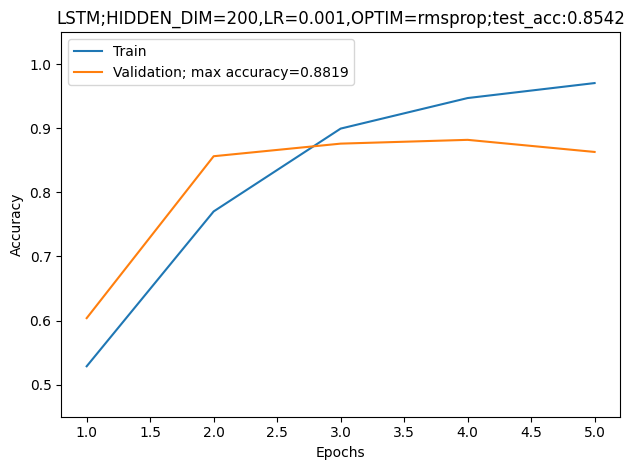

In [46]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_200, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_200, save='y', gru=False)

In [47]:
q2d_rd_260, q2d_hp_260 = train_lab2d(hidden_dimension=260)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 330,771 trainable parameters
Saving ...
epoch: 1
train_loss: 0.711, train_acc: 0.546
valid_loss: 0.700, valid_acc: 0.586
Saving ...
epoch: 2
train_loss: 0.543, train_acc: 0.728
valid_loss: 0.467, valid_acc: 0.788
Saving ...
epoch: 3
train_loss: 0.311, train_acc: 0.875
valid_loss: 0.332, valid_acc: 0.873
Saving ...
epoch: 4
train_loss: 0.169, train_acc: 0.937
valid_loss: 0.375, valid_acc: 0.851
Saving ...
epoch: 5
train_loss: 0.108, train_acc: 0.963
valid_loss: 0.345, valid_acc: 0.872
test_loss: 0.359, test_acc: 0.872


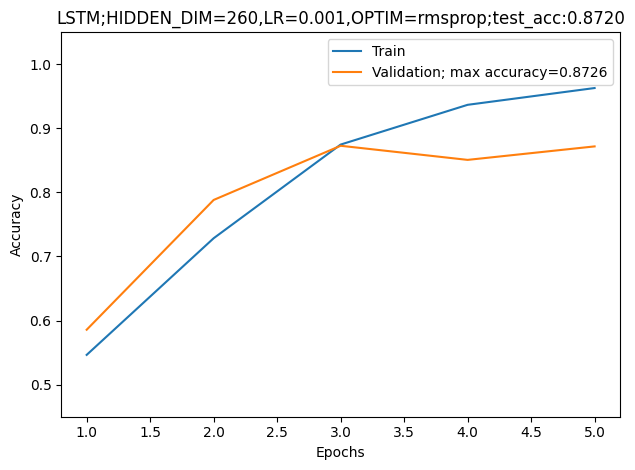

In [48]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_260, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_260, save='y', gru=False)

In [55]:
q2d_rd_285, q2d_hp_285 = train_lab2d(hidden_dimension=285)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 385,621 trainable parameters
Saving ...
epoch: 1
train_loss: 0.669, train_acc: 0.617
valid_loss: 0.398, valid_acc: 0.827
Saving ...
epoch: 2
train_loss: 0.368, train_acc: 0.838
valid_loss: 0.284, valid_acc: 0.888
Saving ...
epoch: 3
train_loss: 0.169, train_acc: 0.937
valid_loss: 0.302, valid_acc: 0.881
Saving ...
epoch: 4
train_loss: 0.093, train_acc: 0.968
valid_loss: 0.315, valid_acc: 0.888
Saving ...
epoch: 5
train_loss: 0.055, train_acc: 0.982
valid_loss: 0.443, valid_acc: 0.883
test_loss: 0.473, test_acc: 0.878


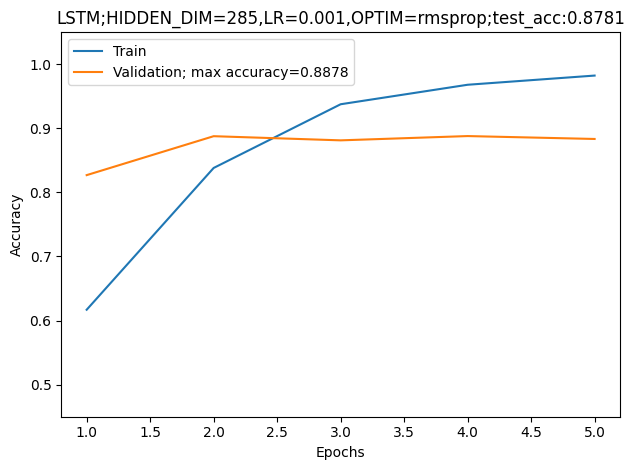

In [56]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_285, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_285, save='y', gru=False)

In [52]:
q2d_rd_319, q2d_hp_319 = train_lab2d(hidden_dimension=319)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 468,241 trainable parameters
Saving ...
epoch: 1
train_loss: 0.750, train_acc: 0.538
valid_loss: 0.686, valid_acc: 0.547
Saving ...
epoch: 2
train_loss: 0.618, train_acc: 0.655
valid_loss: 1.171, valid_acc: 0.528
Saving ...
epoch: 3
train_loss: 0.590, train_acc: 0.688
valid_loss: 0.747, valid_acc: 0.573
Saving ...
epoch: 4
train_loss: 0.491, train_acc: 0.764
valid_loss: 0.762, valid_acc: 0.580
Saving ...
epoch: 5
train_loss: 0.433, train_acc: 0.802
valid_loss: 0.869, valid_acc: 0.572
test_loss: 0.843, test_acc: 0.585


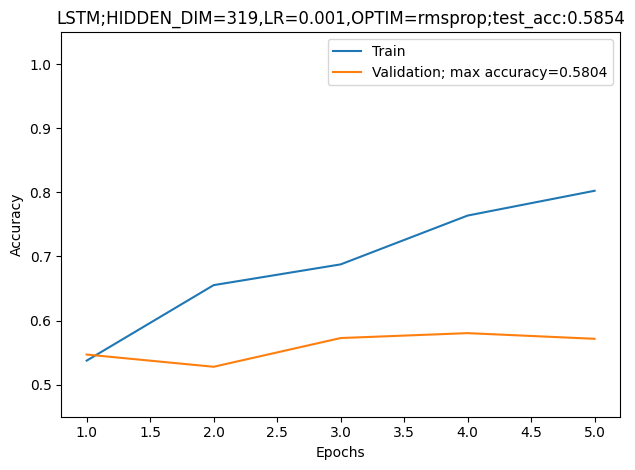

In [54]:
plot_train_val_acc(save_name='q2d', ret_dict=q2d_rd_319, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2d_hp_319, save='y', gru=False)

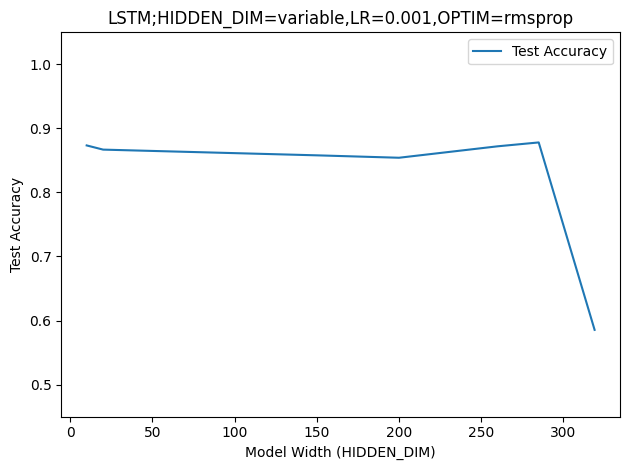

In [82]:
test_losses_q2d = [q2d_rd_10['test_acc'], q2d_rd_20['test_acc'], q2d_rd_150['test_acc'], 
                   q2d_rd_200['test_acc'], q2d_rd_260['test_acc'], q2d_rd_285['test_acc'], 
                   q2d_rd_319['test_acc']]
q2d_hidden_dim = [10, 20, 150, 200, 260, 285, 319]

fig, ax = plt.subplots(1, 1)

ax.plot(q2d_hidden_dim, test_losses_q2d, label='Test Accuracy')

ax.set_ylim([0.45, 1.05])

# diff_param = diff_hparams(orig_hp=orig_hp, new_hp=new_hp)

title_ = "LSTM;HIDDEN_DIM=variable,LR=0.001,OPTIM=rmsprop"

ax.set_xlabel('Model Width (HIDDEN_DIM)')
ax.set_ylabel('Test Accuracy')
ax.legend()
ax.set_title(title_)
fig.tight_layout()
plt.savefig('q2d_overall.pdf', dpi=500, bbox_inches='tight')

### Lab 2 (e) Larger Embedding Table

In [57]:
# (e) (5 pts) Embedding tables contain rich information of the input words and help build a more 
# powerful representation with word vectors. Try to increase the dimension of embeddings. 
# Is your RNN model achieving a better accuracy on IMDB classification? 
# You may use LSTM as an example. 
# (Hint: you do not need to explore an embedding dimension of larger than 256).

def assert_embedding_dim(hp_):
    embedding_dim_max = 256
    assert hp_.EMBEDDING_DIM <= embedding_dim_max and hp_.EMBEDDING_DIM >= 1


def train_lab2e(embedding_dimension):
    # HIDDEN_DIM
    # using lstm. returns ret_dict and hyperparameters instance, changes HIDDEN_DIM
    q2e_rmsprop_HP = HyperParams()
    q2e_rmsprop_HP.LR = 0.001
    q2e_rmsprop_HP.OPTIM = 'rmsprop'

    q2e_rmsprop_HP.EMBEDDING_DIM = embedding_dimension
    assert_h_dim(hp_=q2e_rmsprop_HP)

    ret_dict_2e = train_and_test_model_with_hparams(hparams=q2e_rmsprop_HP, model_type="lstm")
    return ret_dict_2e, q2e_rmsprop_HP

In [58]:
q2e_rd_2, q2e_hp_2 = train_lab2e(embedding_dimension=2)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 155,260 trainable parameters
Saving ...
epoch: 1
train_loss: 0.627, train_acc: 0.678
valid_loss: 0.515, valid_acc: 0.763
Saving ...
epoch: 2
train_loss: 0.299, train_acc: 0.882
valid_loss: 0.320, valid_acc: 0.877
Saving ...
epoch: 3
train_loss: 0.167, train_acc: 0.941
valid_loss: 0.346, valid_acc: 0.848
Saving ...
epoch: 4
train_loss: 0.093, train_acc: 0.969
valid_loss: 0.368, valid_acc: 0.874
Saving ...
epoch: 5
train_loss: 0.054, train_acc: 0.983
valid_loss: 0.445, valid_acc: 0.863
test_loss: 0.439, test_acc: 0.873


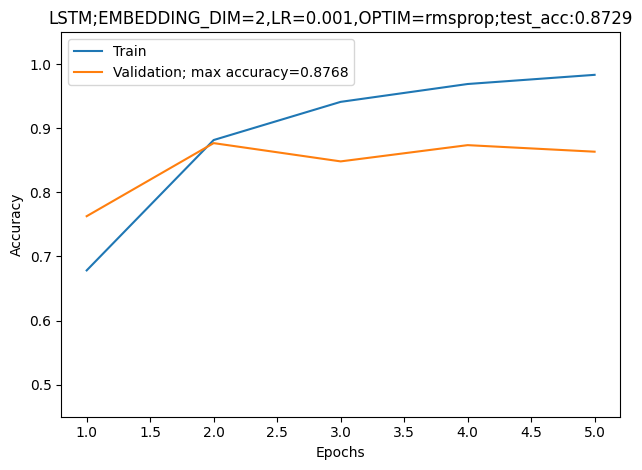

In [59]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_2, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_2, save='y', gru=False)

In [60]:
q2e_rd_8, q2e_hp_8 = train_lab2e(embedding_dimension=8)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 498,034 trainable parameters
Saving ...
epoch: 1
train_loss: 0.491, train_acc: 0.754
valid_loss: 0.384, valid_acc: 0.841
Saving ...
epoch: 2
train_loss: 0.240, train_acc: 0.910
valid_loss: 0.308, valid_acc: 0.880
Saving ...
epoch: 3
train_loss: 0.138, train_acc: 0.952
valid_loss: 0.330, valid_acc: 0.869
Saving ...
epoch: 4
train_loss: 0.085, train_acc: 0.972
valid_loss: 0.372, valid_acc: 0.879
Saving ...
epoch: 5
train_loss: 0.046, train_acc: 0.986
valid_loss: 0.440, valid_acc: 0.858
test_loss: 0.454, test_acc: 0.857


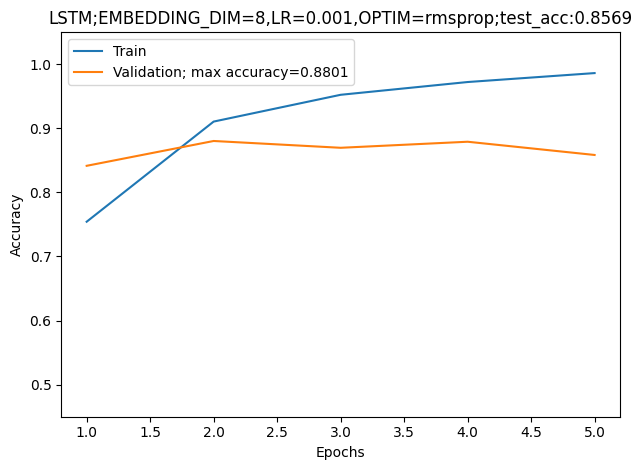

In [61]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_8, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_8, save='y', gru=False)

In [62]:
q2e_rd_32, q2e_hp_32 = train_lab2e(embedding_dimension=32)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 1,869,130 trainable parameters
Saving ...
epoch: 1
train_loss: 0.525, train_acc: 0.748
valid_loss: 0.391, valid_acc: 0.828
Saving ...
epoch: 2
train_loss: 0.258, train_acc: 0.900
valid_loss: 0.399, valid_acc: 0.824
Saving ...
epoch: 3
train_loss: 0.128, train_acc: 0.955
valid_loss: 0.380, valid_acc: 0.862
Saving ...
epoch: 4
train_loss: 0.062, train_acc: 0.980
valid_loss: 0.460, valid_acc: 0.872
Saving ...
epoch: 5
train_loss: 0.029, train_acc: 0.991
valid_loss: 0.516, valid_acc: 0.866
test_loss: 0.565, test_acc: 0.861


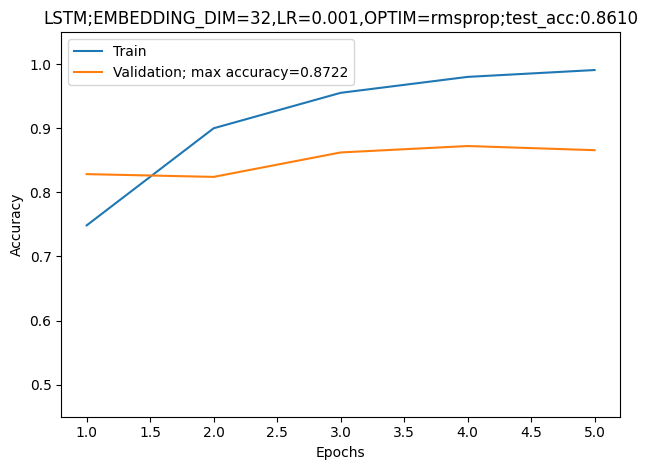

In [63]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_32, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_32, save='y', gru=False)

In [64]:
q2e_rd_64, q2e_hp_64 = train_lab2e(embedding_dimension=64)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 3,697,258 trainable parameters
Saving ...
epoch: 1
train_loss: 0.515, train_acc: 0.745
valid_loss: 0.366, valid_acc: 0.851
Saving ...
epoch: 2
train_loss: 0.242, train_acc: 0.904
valid_loss: 0.293, valid_acc: 0.882
Saving ...
epoch: 3
train_loss: 0.114, train_acc: 0.959
valid_loss: 0.312, valid_acc: 0.877
Saving ...
epoch: 4
train_loss: 0.042, train_acc: 0.986
valid_loss: 0.454, valid_acc: 0.856
Saving ...
epoch: 5
train_loss: 0.016, train_acc: 0.995
valid_loss: 0.727, valid_acc: 0.873
test_loss: 0.723, test_acc: 0.876


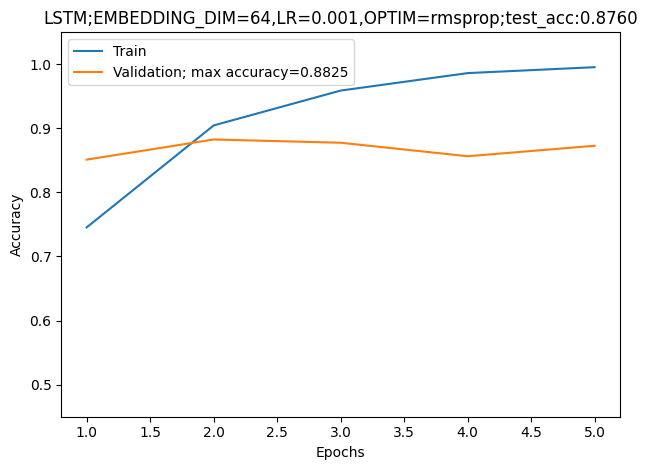

In [65]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_64, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_64, save='y', gru=False)

In [66]:
q2e_rd_128, q2e_hp_128 = train_lab2e(embedding_dimension=128)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 7,353,514 trainable parameters
Saving ...
epoch: 1
train_loss: 0.468, train_acc: 0.774
valid_loss: 0.297, valid_acc: 0.872
Saving ...
epoch: 2
train_loss: 0.195, train_acc: 0.927
valid_loss: 0.320, valid_acc: 0.883
Saving ...
epoch: 3
train_loss: 0.090, train_acc: 0.969
valid_loss: 0.335, valid_acc: 0.882
Saving ...
epoch: 4
train_loss: 0.036, train_acc: 0.989
valid_loss: 0.437, valid_acc: 0.873
Saving ...
epoch: 5
train_loss: 0.016, train_acc: 0.995
valid_loss: 0.601, valid_acc: 0.871
test_loss: 0.626, test_acc: 0.865


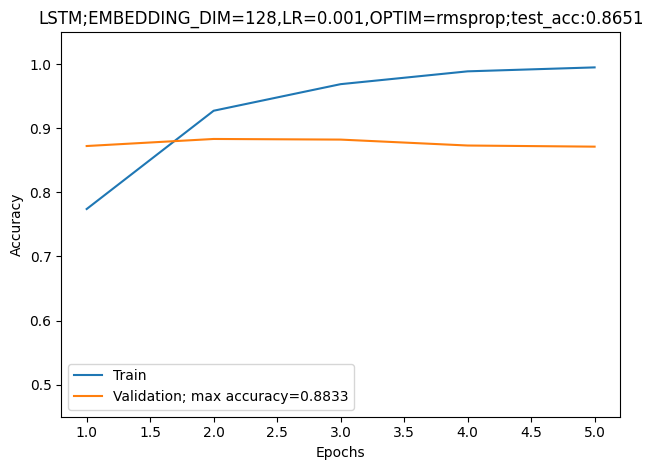

In [67]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_128, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_128, save='y', gru=False)

In [68]:
q2e_rd_188, q2e_hp_188 = train_lab2e(embedding_dimension=188)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 10,781,254 trainable parameters
Saving ...
epoch: 1
train_loss: 0.502, train_acc: 0.752
valid_loss: 0.350, valid_acc: 0.859
Saving ...
epoch: 2
train_loss: 0.229, train_acc: 0.912
valid_loss: 0.296, valid_acc: 0.882
Saving ...
epoch: 3
train_loss: 0.110, train_acc: 0.962
valid_loss: 0.393, valid_acc: 0.881
Saving ...
epoch: 4
train_loss: 0.047, train_acc: 0.984
valid_loss: 0.453, valid_acc: 0.876
Saving ...
epoch: 5
train_loss: 0.023, train_acc: 0.992
valid_loss: 0.596, valid_acc: 0.874
test_loss: 0.604, test_acc: 0.874


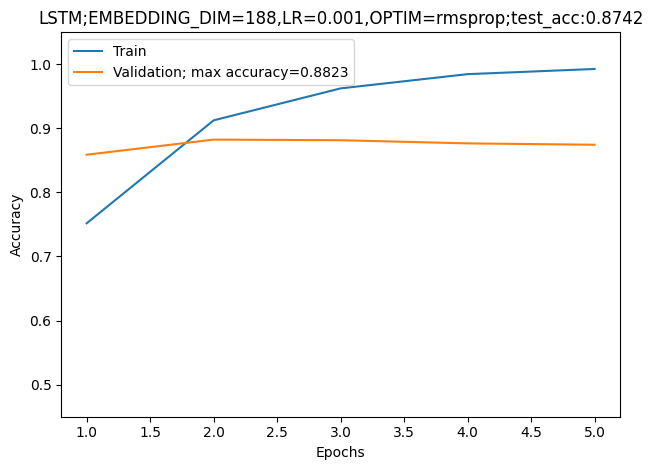

In [69]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_188, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_188, save='y', gru=False)

In [70]:
q2e_rd_256, q2e_hp_256 = train_lab2e(embedding_dimension=256)

shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 14,666,026 trainable parameters
Saving ...
epoch: 1
train_loss: 0.511, train_acc: 0.747
valid_loss: 0.312, valid_acc: 0.872
Saving ...
epoch: 2
train_loss: 0.215, train_acc: 0.917
valid_loss: 0.316, valid_acc: 0.876
Saving ...
epoch: 3
train_loss: 0.107, train_acc: 0.962
valid_loss: 0.375, valid_acc: 0.872
Saving ...
epoch: 4
train_loss: 0.052, train_acc: 0.982
valid_loss: 0.480, valid_acc: 0.869
Saving ...
epoch: 5
train_loss: 0.028, train_acc: 0.991
valid_loss: 0.618, valid_acc: 0.862
test_loss: 0.626, test_acc: 0.860


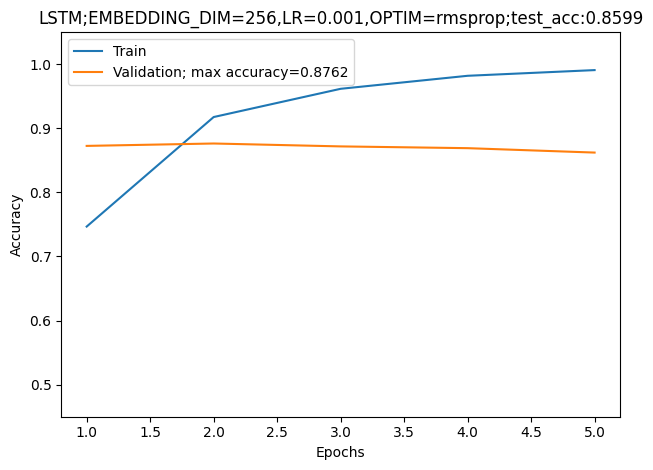

In [71]:
plot_train_val_acc(save_name='q2e', ret_dict=q2e_rd_256, orig_hp=ORIG_HPARAMS, 
                   new_hp=q2e_hp_256, save='y', gru=False)

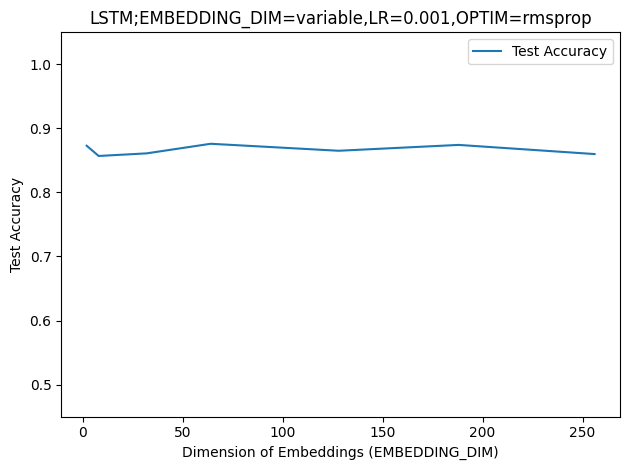

In [81]:
test_losses_q2e = [q2e_rd_2['test_acc'], q2e_rd_8['test_acc'], q2e_rd_32['test_acc'], 
                   q2e_rd_64['test_acc'], q2e_rd_128['test_acc'], q2e_rd_188['test_acc'], 
                   q2e_rd_256['test_acc']]
q2e_embedding_dim = [2, 8, 32, 64, 128, 188, 256]

fig, ax = plt.subplots(1, 1)

ax.plot(q2e_embedding_dim, test_losses_q2e, label='Test Accuracy')

ax.set_ylim([0.45, 1.05])

# diff_param = diff_hparams(orig_hp=orig_hp, new_hp=new_hp)

title_ = "LSTM;EMBEDDING_DIM=variable,LR=0.001,OPTIM=rmsprop"

ax.set_xlabel('Dimension of Embeddings (EMBEDDING_DIM)')
ax.set_ylabel('Test Accuracy')
ax.legend()
ax.set_title(title_)
fig.tight_layout()
plt.savefig('q2e_overall.pdf', dpi=500, bbox_inches='tight')

### Lab 2(f) Compound scaling of embedding_dim, hidden_dim, layers

In [83]:
def assert_all(hp_):
    assert_embedding_dim(hp_)
    assert_h_dim(hp_)
    assert hp_.N_LAYERS >= 1 and hp_.N_LAYERS <= 4
    return

def gen_compound_hparams():
    """
    returns list of hyperparam objects
    """
    # changes embedding_dim, hidden_dim, n_layers, and dropout
    hp_list = []
    num_epochs = 5
    learning_rate = 0.001
    which_optim = "rmsprop"
    
    
    lstm_nlayers = [1, 2, 3, 4]  # part c
    hidden_dim = [20, 280, 290, 305];  # part d
    embedding_table = [32, 188, 256]
    
    
    for idx_out, nlayer in enumerate(lstm_nlayers):
        for idx_mid, hid_dim in enumerate(hidden_dim):
            for idx_in, emb_dim in enumerate(embedding_table):
                temp_hp = HyperParams()
                temp_hp.N_EPOCHS = num_epochs
                temp_hp.LR = learning_rate
                temp_hp.OPTIM = which_optim

                temp_hp.N_LAYERS = nlayer
                temp_hp.HIDDEN_DIM = hid_dim
                temp_hp.EMBEDDING_DIM = emb_dim
                if nlayer >= 3 or hid_dim >= 250 or emb_dim >= 200:
                    temp_hp.DROPOUT_RATE = 0.2
                assert_all(hp_=temp_hp)
                diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=temp_hp)
                hp_list.append(temp_hp)
    return hp_list


def train_compound_hparams(hp_compound_list):
    max_test_acc = -100
    hp_idx_for_max_test_acc = -100
    test_acc_list = []
    for idx_, hp_compound in enumerate(hp_compound_list):
        print('hparam', idx_)
        print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=hp_compound))
        rd_compound = train_and_test_model_with_hparams(hparams=hp_compound, model_type="lstm")
        test_acc_list.append(rd_compound["test_acc"])
        
        if rd_compound["test_acc"] > max_test_acc:
            max_test_acc = rd_compound["test_acc"]
            hp_idx_for_max_test_acc = idx_
        print("\n")
    print('max_test_acc', max_test_acc, '; which_hp', hp_idx_for_max_test_acc)
    print('diff_hp for hp that reached max_test_acc', 
          diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=hp_compound_list[hp_idx_for_max_test_acc]))
    return test_acc_list


hp_list_out = gen_compound_hparams()
test_acc_list_compound = train_compound_hparams(hp_compound_list=hp_list_out)


hparam 0
EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 1,819,690 trainable parameters
Saving ...
epoch: 1
train_loss: 0.549, train_acc: 0.726
valid_loss: 0.335, valid_acc: 0.858
Saving ...
epoch: 2
train_loss: 0.216, train_acc: 0.916
valid_loss: 0.278, valid_acc: 0.890
Saving ...
epoch: 3
train_loss: 0.071, train_acc: 0.977
valid_loss: 0.372, valid_acc: 0.875
Saving ...
epoch: 4
train_loss: 0.022, train_acc: 0.994
valid_loss: 0.482, valid_acc: 0.880
Saving ...
epoch: 5
train_loss: 0.008, train_acc: 0.998
valid_loss: 0.559, valid_acc: 0.874
test_loss: 0.579, test_acc: 0.872


hparam 1
EMBEDDING_DIM=188,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 10,681,894 trainable parameters
Saving ...
epoch: 1
train_loss: 0.549, train_acc: 0.724


TypeError: only integer scalar arrays can be converted to a scalar index

In [87]:
def print_hparam_given_acc(hp_lst, test_acc):
    idx_sorted = np.argsort(test_acc)[::-1]
    diff_hp_lst = []
    for idx in idx_sorted:
        diff_hp = diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=hp_lst[int(idx)])
        print('acc', test_acc[int(idx)], 'diff_hparams', diff_hp)
        diff_hp_lst.append(diff_hp)
    return diff_hp_lst


diff_hparams_lst_sorted = print_hparam_given_acc(hp_lst=hp_list_out, test_acc=test_acc_list_compound)

acc 0.8801587496485029 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
acc 0.8749008133297875 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=188,HIDDEN_DIM=305,LR=0.001,OPTIM=rmsprop
acc 0.8733135115532648 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=256,HIDDEN_DIM=280,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
acc 0.8722222436042059 diff_hparams EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
acc 0.8721230376334418 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=280,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
acc 0.8719246222859337 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=188,HIDDEN_DIM=290,LR=0.001,N_LAYERS=3,OPTIM=rmsprop
acc 0.8718254185858227 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,N_LAYERS=4,OPTIM=rmsprop
acc 0.8717262086414156 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=256,HIDDEN_DIM=290,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
acc 0.8714285918644497 diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=290,

Extracted data from input text 1:
Trainable Parameters: 1819690
Test Loss: 0.579
Test Accuracy: 0.872

Extracted data from input text 2:
Trainable Parameters: 10681894
Test Loss: 0.632
Test Accuracy: 0.863

Extracted data from input text 3:
Trainable Parameters: 14544906
Test Loss: 0.57
Test Accuracy: 0.858

Extracted data from input text 4:
Trainable Parameters: 2167570
Test Loss: 0.692
Test Accuracy: 0.636

Extracted data from input text 5:
Trainable Parameters: 11192014
Test Loss: 0.652
Test Accuracy: 0.858

Extracted data from input text 6:
Trainable Parameters: 15125746
Test Loss: 0.617
Test Accuracy: 0.863

Extracted data from input text 7:
Trainable Parameters: 2191750
Test Loss: 0.364
Test Accuracy: 0.859

Extracted data from input text 8:
Trainable Parameters: 11222434
Test Loss: 0.666
Test Accuracy: 0.869

Extracted data from input text 9:
Trainable Parameters: 15158886
Test Loss: 0.6
Test Accuracy: 0.865

Extracted data from input text 10:
Trainable Parameters: 2229520
Test 

Text(0.5, 1.0, 'Number of trainable Parameters vs Test Accuracy (lab2f)')

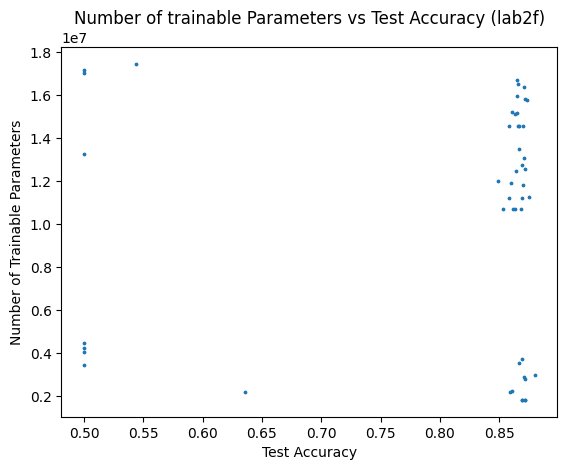

In [15]:
# parsing to get number of parameters and test_accuracy from text file (output of one of the cells)
with open('out_lab2f.txt', 'r') as file:
    file_content = file.read()

# Regular expression pattern to split text based on "hparam idx" where idx is an integer
pattern = r'(hparam \d+)'

# Find all matched patterns in the text
matches = re.finditer(pattern, file_content)

# Split the text using the pattern and include matched patterns in the output
split_strings = re.split(pattern, file_content)

# Remove empty strings from the split result
split_strings = [s.strip() for s in split_strings if s.strip()]
split_strings = [s for s in split_strings if 'hparam' not in s]

splitted_str = []
# Print the split strings along with the matched patterns
for idx, (match, string) in enumerate(zip(matches, split_strings), start=1):
    hparam_line = match.group(1)
    
    splitted_str.append(f'{hparam_line}\n{string}\n')

pattern = r'The model has ([\d,]+) trainable parameters.*?test_loss: (\d+\.\d+), test_acc: (\d+\.\d+)'

idx_list = []
nparam_list = []
test_acc_list = []
# Loop through input texts and extract numbers
for i, input_text in enumerate(splitted_str):
    match = re.search(pattern, input_text, re.DOTALL)
    if match:
        number_with_commas = match.group(1)
        trainable_parameters = int(number_with_commas.replace(',', ''))
        test_loss = float(match.group(2))
        test_acc = float(match.group(3))
        print(f"Extracted data from input text {i + 1}:")
        print(f"Trainable Parameters: {trainable_parameters}")
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_acc}\n")
        test_acc_list.append(test_acc)
        nparam_list.append(trainable_parameters)
        idx_list.append(i)
    else:
        print(f"Data not found in input text {i + 1}.")

idx_sort_test_acc = np.argsort(np.asarray(test_acc_list))[::-1]
sorted_nparam_list = np.asarray(nparam_list)[idx_sort_test_acc]
plt.scatter(np.asarray(test_acc_list)[idx_sort_test_acc], sorted_nparam_list, s=3)
plt.xlabel('Test Accuracy')
plt.ylabel('Number of Trainable Parameters')
plt.title('Number of trainable Parameters vs Test Accuracy (lab2f)')
# plt.savefig('q2f_num_param_vs_acc.pdf', dpi=500, bbox_inches='tight')

In [22]:
input_t = splitted_str

trainable_params_lst = []
test_acc_lst = []
for input_text in input_t:
    trainable_parameters = re.search(r'The model has (\d+(,\d{3})*) trainable parameters', input_text)
    test_loss_acc = re.search(r'test_loss: (\d+\.\d+), test_acc: (\d+\.\d+)', input_text)

    # Extracted values
    trainable_parameters_value = trainable_parameters.group(1).replace(',', '')
    test_loss_value = test_loss_acc.group(1)
    test_acc_value = test_loss_acc.group(2)
    
    trainable_params_lst.append(int(trainable_parameters_value))
    test_acc_lst.append(float(test_acc_value))
    # Print the extracted values
    # print("Trainable Parameters:", trainable_parameters_value)
    # print("Test Loss:", test_loss_value)
    # print("Test Accuracy:", test_acc_value)

def rank_given_acc_and_num_params(test_acc=test_acc_lst, num_params=trainable_params_lst):
    ratio = [test_acc[i] / num_params[i] for i in range(len(test_acc_lst))]
    idx_sorted = np.argsort(np.array(ratio))[::-1]
    for idx in idx_sorted:
        print('index %d, acc %.5f, num_params %d, acc/num_params %g' 
              % (idx, test_acc[int(idx)], num_params[int(idx)], test_acc[int(idx)] / num_params[int(idx)]))
    return 

rank_given_acc_and_num_params()
# note: for "acc %.5f" e.g. "acc 0.87200" in the first line, disregard trailing zeros. The precision is to 
# 3 decimal places only. 

index 0, acc 0.87200, num_params 1819690, acc/num_params 4.79203e-07
index 12, acc 0.86900, num_params 1823050, acc/num_params 4.76674e-07
index 36, acc 0.87200, num_params 1829770, acc/num_params 4.76563e-07
index 24, acc 0.86900, num_params 1826410, acc/num_params 4.75797e-07
index 6, acc 0.85900, num_params 2191750, acc/num_params 3.91924e-07
index 9, acc 0.86100, num_params 2229520, acc/num_params 3.86182e-07
index 15, acc 0.87200, num_params 2797010, acc/num_params 3.11761e-07
index 18, acc 0.87100, num_params 2866870, acc/num_params 3.03816e-07
index 21, acc 0.88000, num_params 2976160, acc/num_params 2.95683e-07
index 3, acc 0.63600, num_params 2167570, acc/num_params 2.93416e-07
index 30, acc 0.86700, num_params 3541990, acc/num_params 2.44778e-07
index 33, acc 0.86900, num_params 3722800, acc/num_params 2.33426e-07
index 27, acc 0.50000, num_params 3426450, acc/num_params 1.45924e-07
index 39, acc 0.50000, num_params 4055890, acc/num_params 1.23278e-07
index 42, acc 0.50000, n

### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)

In [89]:
# diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
# note: this is the optimal hparam setting for BIDIRECTIONAL = False when considering accuracy only
bi_dir_hp = HyperParams()

bi_dir_hp.BIDIRECTIONAL = True

bi_dir_hp.DROPOUT_RATE = 0.2
bi_dir_hp.EMBEDDING_DIM = 32
bi_dir_hp.HIDDEN_DIM = 305
bi_dir_hp.LR = 0.001
bi_dir_hp.N_LAYERS = 2
bi_dir_hp.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=bi_dir_hp))

rd_2g_bidirect = train_and_test_model_with_hparams(hparams=bi_dir_hp, model_type="lstm")

BIDIRECTIONAL=True,DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 4,881,190 trainable parameters
Saving ...
epoch: 1
train_loss: 0.669, train_acc: 0.601
valid_loss: 0.613, valid_acc: 0.646
Saving ...
epoch: 2
train_loss: 0.463, train_acc: 0.785
valid_loss: 0.399, valid_acc: 0.824
Saving ...
epoch: 3
train_loss: 0.275, train_acc: 0.889
valid_loss: 0.384, valid_acc: 0.832
Saving ...
epoch: 4
train_loss: 0.205, train_acc: 0.922
valid_loss: 0.386, valid_acc: 0.864
Saving ...
epoch: 5
train_loss: 0.152, train_acc: 0.946
valid_loss: 0.433, valid_acc: 0.854
test_loss: 0.429, test_acc: 0.857


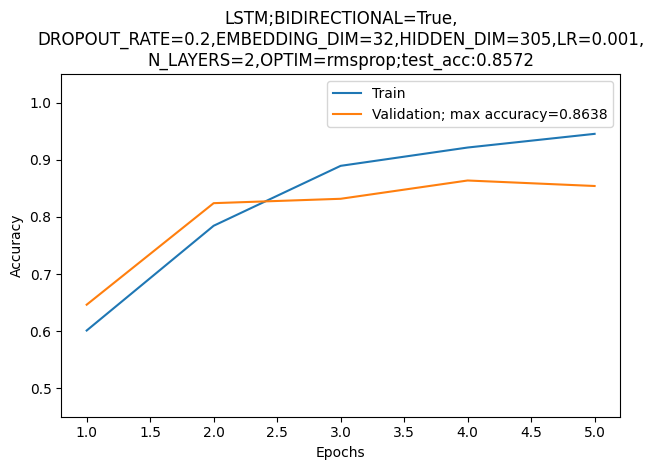

In [124]:
plot_train_val_acc(save_name='q2g_bestHP', ret_dict=rd_2g_bidirect, orig_hp=ORIG_HPARAMS, 
                   new_hp=bi_dir_hp, save='y', gru=False)

In [14]:
# diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
# note: this is the optimal hparam setting for BIDIRECTIONAL = False 
# (found using LSTM when considering accuracy only)
# this is trained using the GRU model
bi_dir_hp_gru = HyperParams()

bi_dir_hp_gru.BIDIRECTIONAL = True

bi_dir_hp_gru.DROPOUT_RATE = 0.2
bi_dir_hp_gru.EMBEDDING_DIM = 32
bi_dir_hp_gru.HIDDEN_DIM = 305
bi_dir_hp_gru.LR = 0.001
bi_dir_hp_gru.N_LAYERS = 2
bi_dir_hp_gru.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=bi_dir_hp_gru))

rd_2g_bidirect_gru = train_and_test_model_with_hparams(hparams=bi_dir_hp_gru, 
                                                       model_type="gru",
                                                       override_models_with_gru=True)

BIDIRECTIONAL=True,
DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,
N_LAYERS=2,OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 4,115,030 trainable parameters
Saving ...
epoch: 1
train_loss: 0.425, train_acc: 0.800
valid_loss: 0.283, valid_acc: 0.893
Saving ...
epoch: 2
train_loss: 0.185, train_acc: 0.936
valid_loss: 0.349, valid_acc: 0.882
Saving ...
epoch: 3
train_loss: 0.085, train_acc: 0.971
valid_loss: 0.545, valid_acc: 0.873
Saving ...
epoch: 4
train_loss: 0.047, train_acc: 0.985
valid_loss: 0.541, valid_acc: 0.873
Saving ...
epoch: 5
train_loss: 0.041, train_acc: 0.988
valid_loss: 0.910, valid_acc: 0.872
test_loss: 0.924, test_acc: 0.867


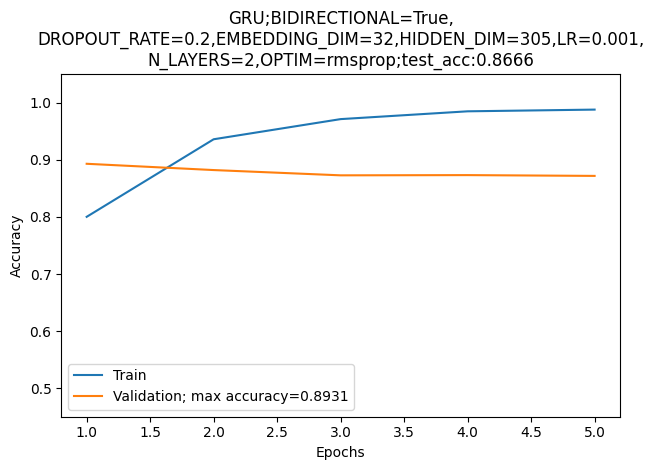

In [22]:
plot_train_val_acc(save_name='q2g_bestHP_gru_bidir', ret_dict=rd_2g_bidirect_gru, orig_hp=ORIG_HPARAMS, 
                   new_hp=bi_dir_hp_gru, save='y', gru=True)

In [19]:
# diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,OPTIM=rmsprop
# note: this is the optimal hparam setting for BIDIRECTIONAL = False (found using LSTM)
best_hp_gru = HyperParams()

best_hp_gru.BIDIRECTIONAL = False

best_hp_gru.DROPOUT_RATE = 0.2
best_hp_gru.EMBEDDING_DIM = 32
best_hp_gru.HIDDEN_DIM = 305
best_hp_gru.LR = 0.001
best_hp_gru.N_LAYERS = 2
best_hp_gru.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=best_hp_gru))

rd_2g_best_hp_gru = train_and_test_model_with_hparams(hparams=best_hp_gru, 
                                                      model_type="gru",
                                                      override_models_with_gru=True)

DROPOUT_RATE=0.2,
EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=2,
OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 2,686,105 trainable parameters
Saving ...
epoch: 1
train_loss: 0.421, train_acc: 0.804
valid_loss: 0.268, valid_acc: 0.888
Saving ...
epoch: 2
train_loss: 0.144, train_acc: 0.948
valid_loss: 0.318, valid_acc: 0.885
Saving ...
epoch: 3
train_loss: 0.056, train_acc: 0.981
valid_loss: 0.379, valid_acc: 0.876
Saving ...
epoch: 4
train_loss: 0.033, train_acc: 0.988
valid_loss: 0.541, valid_acc: 0.877
Saving ...
epoch: 5
train_loss: 0.019, train_acc: 0.994
valid_loss: 0.654, valid_acc: 0.877
test_loss: 0.635, test_acc: 0.882


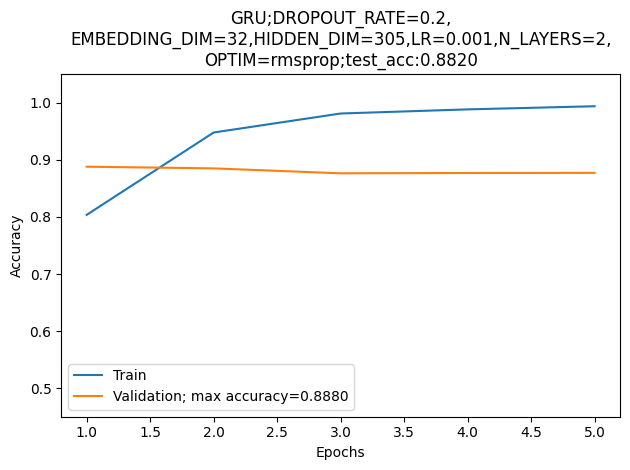

In [20]:
plot_train_val_acc(save_name='q2g_bestHP_gru_singledir', ret_dict=rd_2g_best_hp_gru, orig_hp=ORIG_HPARAMS, 
                   new_hp=best_hp_gru, save='y', gru=True)

In [96]:
# diff_hparams DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,N_LAYERS=1,OPTIM=rmsprop
# note: this is the optimal hparam setting for BIDIRECTIONAL = False EXCEPT N_LAYERS=1 
# in this case
# this means that the model has less trainable parameters

bi_dir_hp2 = HyperParams()

bi_dir_hp2.BIDIRECTIONAL = True

bi_dir_hp2.DROPOUT_RATE = 0.2
bi_dir_hp2.EMBEDDING_DIM = 32
bi_dir_hp2.HIDDEN_DIM = 305
bi_dir_hp2.LR = 0.001
bi_dir_hp2.N_LAYERS = 1
bi_dir_hp2.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=bi_dir_hp2))

rd_2g2_bidirect = train_and_test_model_with_hparams(hparams=bi_dir_hp2, model_type="lstm")

BIDIRECTIONAL=True,
DROPOUT_RATE=0.2,EMBEDDING_DIM=32,HIDDEN_DIM=305,LR=0.001,
OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 2,643,710 trainable parameters
Saving ...
epoch: 1
train_loss: 0.566, train_acc: 0.711
valid_loss: 0.394, valid_acc: 0.823
Saving ...
epoch: 2
train_loss: 0.253, train_acc: 0.899
valid_loss: 0.313, valid_acc: 0.869
Saving ...
epoch: 3
train_loss: 0.118, train_acc: 0.958
valid_loss: 0.338, valid_acc: 0.879
Saving ...
epoch: 4
train_loss: 0.049, train_acc: 0.984
valid_loss: 0.429, valid_acc: 0.874
Saving ...
epoch: 5
train_loss: 0.018, train_acc: 0.994
valid_loss: 0.579, valid_acc: 0.874
test_loss: 0.585, test_acc: 0.869


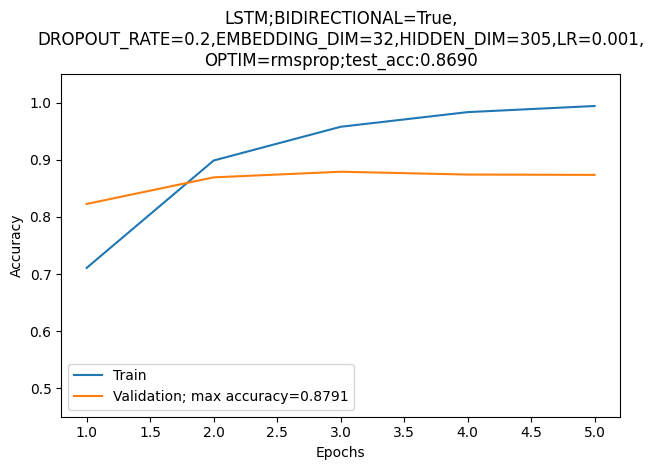

In [97]:
plot_train_val_acc(save_name='q2g_otherHP', ret_dict=rd_2g2_bidirect, orig_hp=ORIG_HPARAMS, 
                   new_hp=bi_dir_hp2, save='y', gru=False)

In [23]:
# hparam 0: EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
# this is the best model using acc/num_param criterion

bi_dir_hp_acc_num_param = HyperParams()

bi_dir_hp_acc_num_param.BIDIRECTIONAL = True

bi_dir_hp_acc_num_param.EMBEDDING_DIM = 32
bi_dir_hp_acc_num_param.HIDDEN_DIM = 20
bi_dir_hp_acc_num_param.LR = 0.001
bi_dir_hp_acc_num_param.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=bi_dir_hp_acc_num_param))

rd_2g_bidirect_acc_numparam = train_and_test_model_with_hparams(hparams=bi_dir_hp_acc_num_param, 
                                                                model_type="lstm")

BIDIRECTIONAL=True,
EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop,
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 1,824,050 trainable parameters
Saving ...
epoch: 1
train_loss: 0.533, train_acc: 0.730
valid_loss: 0.401, valid_acc: 0.829
Saving ...
epoch: 2
train_loss: 0.220, train_acc: 0.915
valid_loss: 0.289, valid_acc: 0.885
Saving ...
epoch: 3
train_loss: 0.084, train_acc: 0.973
valid_loss: 0.352, valid_acc: 0.888
Saving ...
epoch: 4
train_loss: 0.028, train_acc: 0.992
valid_loss: 0.491, valid_acc: 0.872
Saving ...
epoch: 5
train_loss: 0.011, train_acc: 0.997
valid_loss: 0.646, valid_acc: 0.871
test_loss: 0.638, test_acc: 0.870


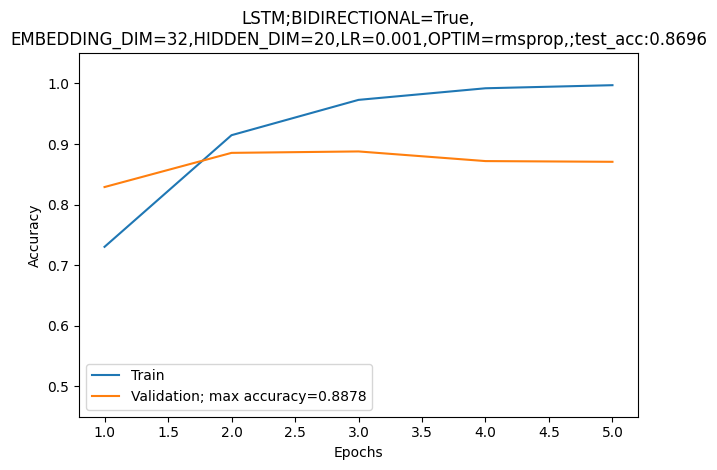

In [28]:
plot_train_val_acc(save_name='q2g_bidir_bestHP_acc_nparams', ret_dict=rd_2g_bidirect_acc_numparam, 
                   orig_hp=ORIG_HPARAMS, new_hp=bi_dir_hp_acc_num_param, save='y', gru=False)

In [25]:
# hparam 0: EMBEDDING_DIM=32,HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
# this is the best model using acc/num_param criterion (found using LSTM)

## NOTE: THIS IS FOR UNI-DIRECTIONAL, as a comparison

best_hp_acc_num_param = HyperParams()

best_hp_acc_num_param.BIDIRECTIONAL = False

best_hp_acc_num_param.EMBEDDING_DIM = 32
best_hp_acc_num_param.HIDDEN_DIM = 20
best_hp_acc_num_param.LR = 0.001
best_hp_acc_num_param.OPTIM = 'rmsprop'

print(diff_hparams(orig_hp=ORIG_HPARAMS, new_hp=best_hp_acc_num_param))

rd_2g_best_acc_numparam = train_and_test_model_with_hparams(hparams=best_hp_acc_num_param, 
                                                                model_type="lstm")

EMBEDDING_DIM=32,
HIDDEN_DIM=20,LR=0.001,OPTIM=rmsprop
shape of train data is 35000
shape of test data is 10000
shape of valid data is 5000
Length of vocabulary is 56729
The model has 1,819,690 trainable parameters
Saving ...
epoch: 1
train_loss: 0.549, train_acc: 0.726
valid_loss: 0.335, valid_acc: 0.858
Saving ...
epoch: 2
train_loss: 0.216, train_acc: 0.916
valid_loss: 0.278, valid_acc: 0.890
Saving ...
epoch: 3
train_loss: 0.071, train_acc: 0.977
valid_loss: 0.372, valid_acc: 0.875
Saving ...
epoch: 4
train_loss: 0.022, train_acc: 0.994
valid_loss: 0.482, valid_acc: 0.880
Saving ...
epoch: 5
train_loss: 0.008, train_acc: 0.998
valid_loss: 0.559, valid_acc: 0.874
test_loss: 0.579, test_acc: 0.872


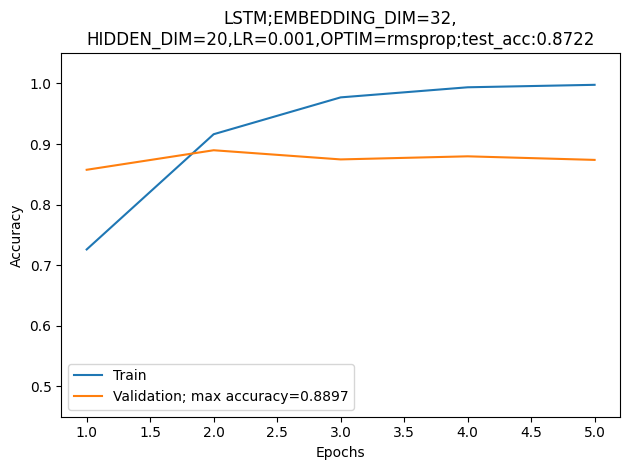

In [27]:
plot_train_val_acc(save_name='q2g_unidir_bestHP_acc_nparams', ret_dict=rd_2g_best_acc_numparam, 
                   orig_hp=ORIG_HPARAMS, new_hp=best_hp_acc_num_param, save='y', gru=False)